In [1]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
 
    :return: pandas DataFrame containing stock orders
 
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
 
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
 
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].ix[-1, "Regime"]
        s[1].ix[-1, "Regime"] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].ix[-1, "Regime"] = regime_orig
 
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
 
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 
 
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
 
    :return: pandas DataFrame with backtesting results
 
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
 
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
 
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
 
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
 
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
 
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results

def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})

In [2]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9) 

start = datetime.datetime(2007,1,1)
end = datetime.date.today()

sl = ['PCLN','HBANP','AMZN','GOOG','ISRG','ATRI','UHAL','REGN','EQIX','CHTR','ULTA','TSLA', 'WINS']

# Get more stocks
apple = web.DataReader(sl[0], "yahoo", start, end)
microsoft = web.DataReader(sl[1], "yahoo", start, end)
google = web.DataReader(sl[2], "yahoo", start, end)
facebook = web.DataReader(sl[3], "yahoo", start, end)
twitter = web.DataReader(sl[4], "yahoo", start, end)
netflix = web.DataReader(sl[5], "yahoo", start, end)
amazon = web.DataReader(sl[6], "yahoo", start, end)
yahoo = web.DataReader(sl[7], "yahoo", start, end)
sony = web.DataReader(sl[8], "yahoo", start, end)
tesla = web.DataReader(sl[9], "yahoo", start, end)
ibm = web.DataReader(sl[10], "yahoo", start, end)
hp = web.DataReader(sl[11], "yahoo", start, end)

signals = ma_crossover_orders([(sl[0], ohlc_adj(apple)),
                              (sl[1],  ohlc_adj(microsoft)),
                              (sl[2],  ohlc_adj(google)),
                              (sl[3],    ohlc_adj(facebook)),
                              (sl[4],  ohlc_adj(twitter)),
                              (sl[5],  ohlc_adj(netflix)),
                              (sl[6],  ohlc_adj(amazon)),
                              (sl[7],  ohlc_adj(yahoo)),
                              (sl[8],   ohlc_adj(yahoo)),
                              (sl[9], ohlc_adj(tesla)),
                              (sl[10],   ohlc_adj(ibm)),
                              (sl[11],   ohlc_adj(hp))],
                            fast = 20, slow = 50)
signals

Populating the interactive namespace from numpy and matplotlib


Price  Regime Signal
Date       Symbol                            
2007-03-15 AMZN      37.779999     1.0    Buy
           ATRI      73.168680     1.0    Buy
           EQIX      18.570000    -1.0   Sell
           GOOG     222.872504    -1.0   Sell
           ISRG     111.589996     1.0    Buy
           PCLN      51.660000     1.0    Buy
           REGN      18.570000    -1.0   Sell
           UHAL      61.887403    -1.0   Sell
2007-03-23 ATRI      74.167850    -1.0   Sell
2007-03-26 AMZN      39.009998    -1.0   Sell
2007-03-30 AMZN      39.790001     0.0    Buy
2007-04-02 AMZN      40.419998     1.0    Buy
2007-04-09 EQIX      23.959999     1.0    Buy
           REGN      23.959999     1.0    Buy
2007-04-13 GOOG     232.912492     1.0    Buy
           UHAL      65.027959     1.0    Buy
2007-05-10 ATRI      76.370939     1.0    Buy
2007-05-23 UHAL      63.503865    -1.0   Sell
2007-06-05 EQIX      19.940001    -1.0   Sell
           REGN      19.940001    -1.0   Sell
2007-06-08 UHAL      73.793800     1.0    Buy
2007-07-23 UHAL      61.554873    -1.0   Sell
2007-08-10 GOOG     257.617812    -1.0   Sell
2007-08-30 EQIX      18.940001     1.0    Buy
           REGN      18.940001     1.0    Buy
2007-09-19 GOOG     273.152315     1.0    Buy
2007-10-08 UHAL      61.490215     1.0    Buy
2007-10-12 EQIX      19.450001     0.0   Sell
           REGN      19.450001     0.0   Sell
2007-10-15 EQIX      20.680000    -1.0   Sell
...                        ...     ...    ...
2016-11-16 ULTA     246.619995    -1.0   Sell
2016-11-17 HBANP   1343.848427    -1.0   Sell
2016-11-18 GOOG     760.539978    -1.0   Sell
2016-11-28 EQIX     390.380005     1.0    Buy
           REGN     390.380005     1.0    Buy
           UHAL     341.809998     1.0    Buy
           ULTA     261.600006     1.0    Buy
2016-11-29 CHTR     280.489990     1.0    Buy
2016-12-21 EQIX     365.059998    -1.0   Sell
           REGN     365.059998    -1.0   Sell
           TSLA     207.699997     1.0    Buy
2016-12-23 GOOG     789.909973     1.0    Buy
2017-01-09 AMZN     796.919983     1.0    Buy
           PCLN    1529.640015    -1.0   Sell
2017-01-17 ISRG     663.739990     1.0    Buy
2017-01-19 HBANP   1383.630005     1.0    Buy
2017-01-23 ATRI     465.100006    -1.0   Sell
2017-01-24 PCLN    1563.329956     1.0    Buy
2017-02-07 AMZN     812.500000     1.0   Sell
           ATRI     468.700012    -1.0    Buy
           CHTR     323.369995     1.0   Sell
           EQIX     357.690002    -1.0    Buy
           GOOG     806.969971     1.0   Sell
           HBANP   1382.000000     1.0   Sell
           ISRG     704.239990     1.0   Sell
           PCLN    1598.699951     1.0   Sell
           REGN     357.690002    -1.0    Buy
           TSLA     257.480011     1.0   Sell
           UHAL     371.000000     1.0   Sell
           ULTA     272.489990     1.0   Sell

[651 rows x 3 columns]

In [3]:
bk = backtest(signals, 1000000)
bk

End Cash  Portfolio Value  Profit per Share  \
Date       Symbol                                                    
2007-03-15 AMZN    9.017720e+05     1.000000e+06          0.000000   
           ATRI    8.066527e+05     1.000000e+06          0.000000   
           EQIX    8.066527e+05     1.000000e+06          0.000000   
           GOOG    8.066527e+05     1.000000e+06          0.000000   
           ISRG    7.173807e+05     1.000000e+06          0.000000   
           PCLN    6.192267e+05     1.000000e+06          0.000000   
           REGN    6.192267e+05     1.000000e+06          0.000000   
           UHAL    6.192267e+05     1.000000e+06          0.000000   
2007-03-23 ATRI    7.156449e+05     1.001299e+06          0.999170   
2007-03-26 AMZN    8.170709e+05     1.004497e+06          1.229999   
2007-03-30 AMZN    8.170709e+05     1.004497e+06          2.010002   
2007-04-02 AMZN    7.200629e+05     1.004497e+06          0.000000   
2007-04-09 EQIX    6.218269e+05     1.004497e+06          0.000000   
           REGN    5.235909e+05     1.004497e+06          0.000000   
2007-04-13 GOOG    4.304259e+05     1.004497e+06          0.000000   
           UHAL    3.328840e+05     1.004497e+06          0.000000   
2007-05-10 ATRI    2.336018e+05     1.004497e+06          0.000000   
2007-05-23 UHAL    3.288576e+05     1.002211e+06         -1.524094   
2007-06-05 EQIX    4.106116e+05     9.857288e+05         -4.019998   
           REGN    4.923656e+05     9.692468e+05         -4.019998   
2007-06-08 UHAL    3.964336e+05     9.692468e+05          0.000000   
2007-07-23 UHAL    4.764550e+05     9.533362e+05        -12.238927   
2007-08-10 GOOG    5.795021e+05     9.632183e+05         24.705320   
2007-08-30 EQIX    4.848021e+05     9.632183e+05          0.000000   
           REGN    3.901021e+05     9.632183e+05          0.000000   
2007-09-19 GOOG    3.081564e+05     9.632183e+05          0.000000   
2007-10-08 UHAL    2.159211e+05     9.632183e+05          0.000000   
2007-10-12 EQIX    3.131711e+05     9.657683e+05          0.510000   
           REGN    4.104211e+05     9.683183e+05          0.510000   
2007-10-15 EQIX    4.104211e+05     9.683183e+05          1.739999   
...                         ...              ...               ...   
2016-11-16 ULTA    3.622639e+06     5.361498e+06          4.309997   
2016-11-17 HBANP   4.025794e+06     5.380445e+06         63.155135   
2016-11-18 GOOG    4.482118e+06     5.365204e+06        -25.400024   
2016-11-28 EQIX    3.974624e+06     5.365204e+06          0.000000   
           REGN    3.467130e+06     5.365204e+06          0.000000   
           UHAL    2.954415e+06     5.365204e+06          0.000000   
           ULTA    2.431215e+06     5.365204e+06          0.000000   
2016-11-29 CHTR    1.898284e+06     5.365204e+06          0.000000   
2016-12-21 EQIX    2.372862e+06     5.332288e+06        -25.320007   
           REGN    2.847440e+06     5.299372e+06        -25.320007   
           TSLA    2.328190e+06     5.299372e+06          0.000000   
2016-12-23 GOOG    1.854244e+06     5.299372e+06          0.000000   
2017-01-09 AMZN    1.376092e+06     5.299372e+06          0.000000   
           PCLN    1.834984e+06     5.361763e+06        207.969971   
2017-01-17 ISRG    1.303992e+06     5.361763e+06          0.000000   
2017-01-19 HBANP   8.889026e+05     5.361763e+06          0.000000   
2017-01-23 ATRI    1.400513e+06     5.386788e+06         22.749176   
2017-01-24 PCLN    9.315136e+05     5.386788e+06          0.000000   
2017-02-07 AMZN    1.419014e+06     5.396136e+06         15.580017   
           ATRI    1.419014e+06     5.396136e+06         26.349182   
           CHTR    2.033417e+06     5.477608e+06         42.880005   
           EQIX    2.033417e+06     5.477608e+06        -32.690003   
           GOOG    2.517599e+06     5.487844e+06         17.059998   
           HBANP   2.932199e+06     5.487355e+06         -1.630005   
           ISRG    3.495591e+06  

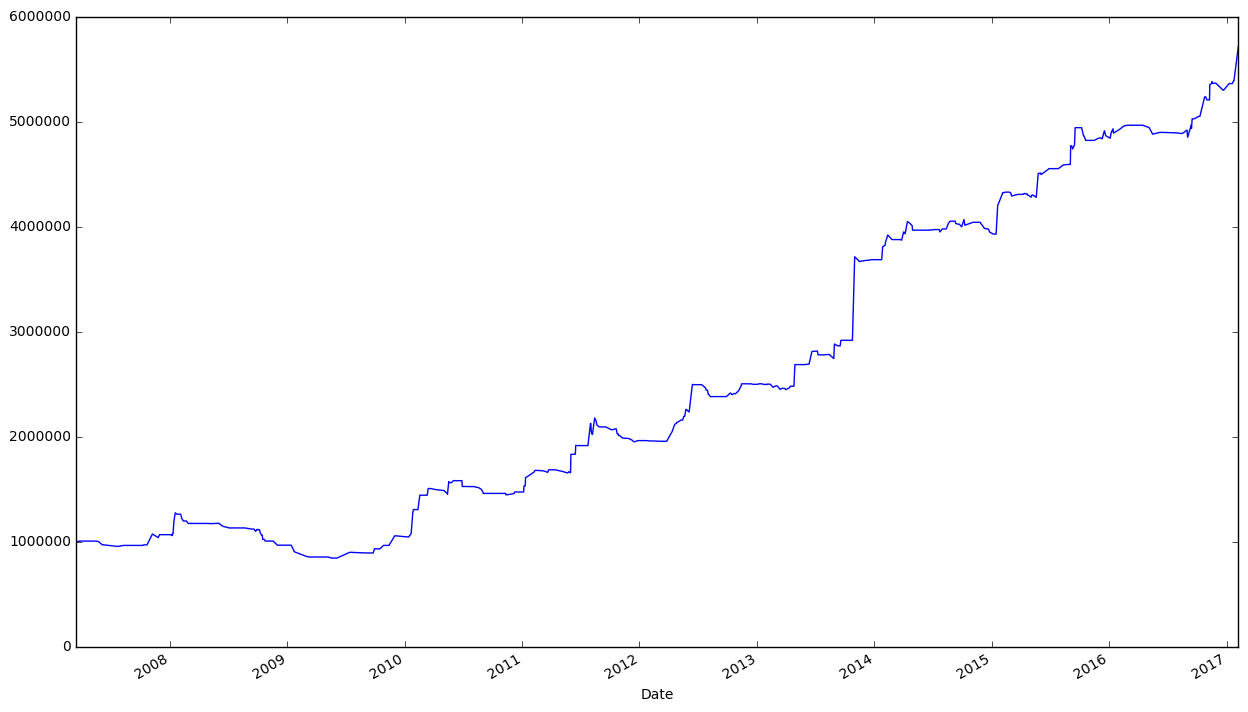

In [4]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

In [5]:
spyder = web.DataReader("SPY", "yahoo", start, end)
spyder.iloc[[0,-1],:]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2007-01-03,142.250000,142.860001,140.570007,141.369995,94807600,114.809403
2017-02-07,229.380005,229.660004,228.720001,228.940002,54614900,228.940002


In [6]:
batch = 100 
batches = 1000000 // np.ceil(100 * spyder.ix[0,"Adj Close"]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.ix[0,"Adj Close"] # How much money is used to buy SPY
final_val = batches * batch * spyder.ix[-1,"Adj Close"] + (1000000 - trade_val) # Final value of the portfolio
final_val

1992936.2113000001

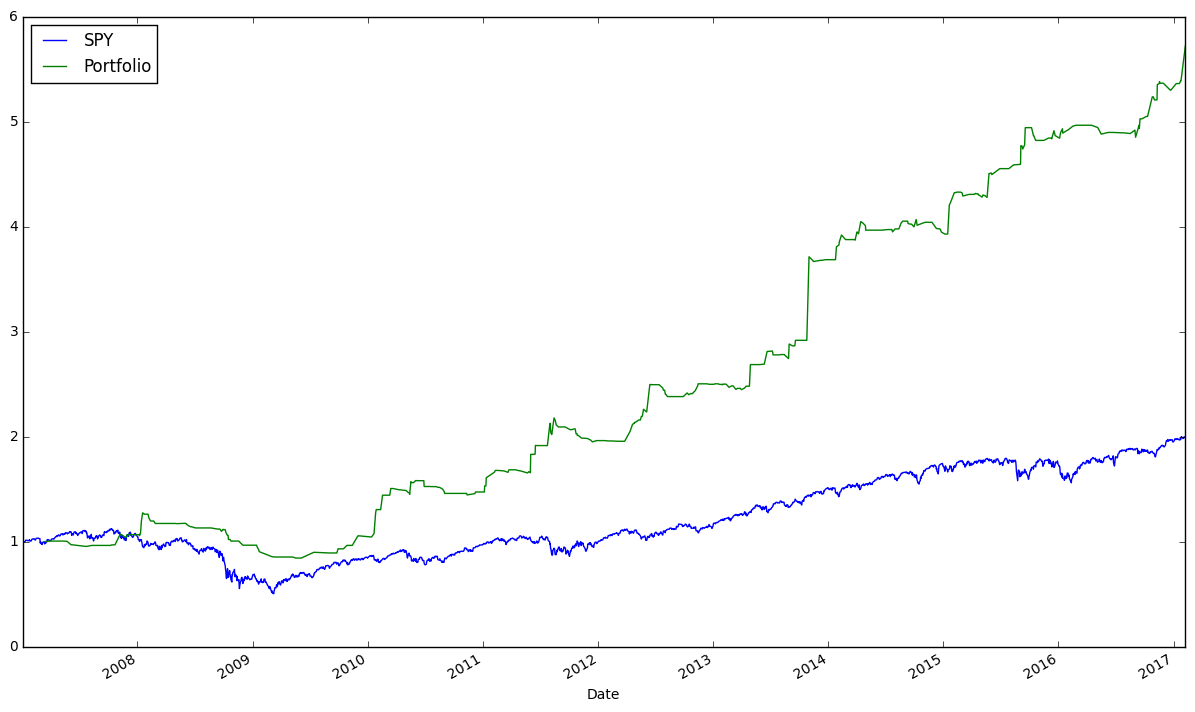

In [7]:
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"] / spyder.ix[0, "Adj Close"]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 1000000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench